# 结构性数据建模
## 泰坦尼克号幸存者，二分类

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

train_df = pd.read_csv('../data/titanic/train.csv')
test_df = pd.read_csv('../data/titanic/test.csv')
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S
1,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
2,388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0000,NaN,S
3,192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S
4,687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S


字段说明：

- Survived:0代表死亡，1代表存活【y标签】
- Pclass:乘客所持票类，有三种值(1,2,3) 【转换成onehot编码】
- Name:乘客姓名 【舍去】
- Sex:乘客性别 【转换成bool特征】
- Age:乘客年龄(有缺失) 【数值特征，添加“年龄是否缺失”作为辅助特征】
- SibSp:乘客兄弟姐妹/配偶的个数(整数值) 【数值特征】
- Parch:乘客父母/孩子的个数(整数值)【数值特征】
- Ticket:票号(字符串)【舍去】
- Fare:乘客所持票的价格(浮点数，0-500不等) 【数值特征】
- Cabin:乘客所在船舱(有缺失) 【添加“所在船舱是否缺失”作为辅助特征】
- Embarked:乘客登船港口:S、C、Q(有缺失)【转换成onehot编码，四维度 S,C,Q,nan】

利用Pandas的数据可视化功能我们可以简单地进行探索性数据分析EDA（Exploratory Data Analysis）。

### label分布情况

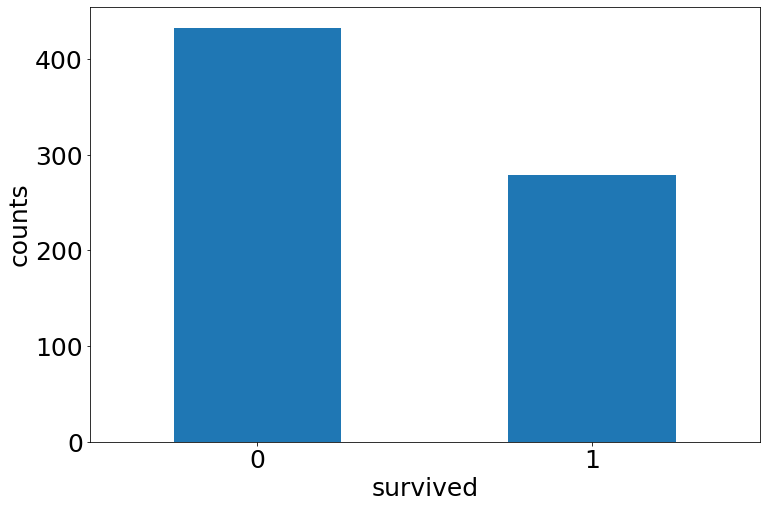

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

ax = train_df['Survived'].value_counts().plot(
    kind = 'bar',figsize = (12,8),fontsize=25,rot = 0)
ax.set_ylabel('counts',fontsize = 25)
ax.set_xlabel('survived',fontsize = 25)
plt.show()

### 年龄分布情况


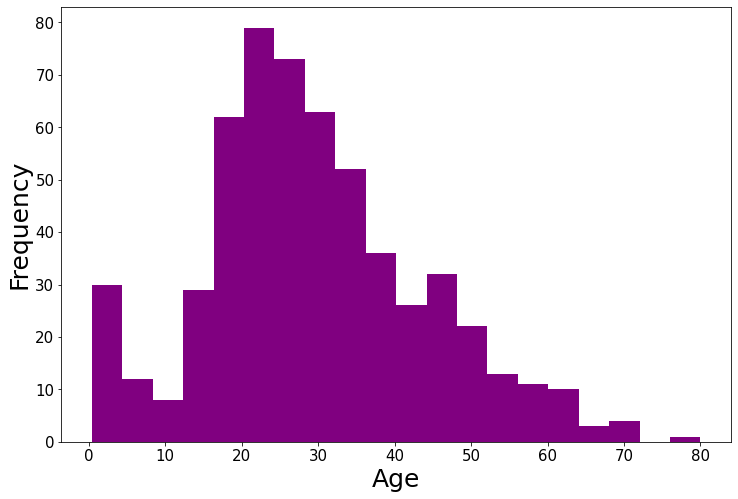

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = train_df['Age'].plot(
    kind = 'hist',bins = 20,color= 'purple',figsize = (12,8),fontsize=15)

ax.set_ylabel('Frequency', fontsize=25)
ax.set_xlabel('Age', fontsize=25)
plt.show()

### 年龄和label的相关性

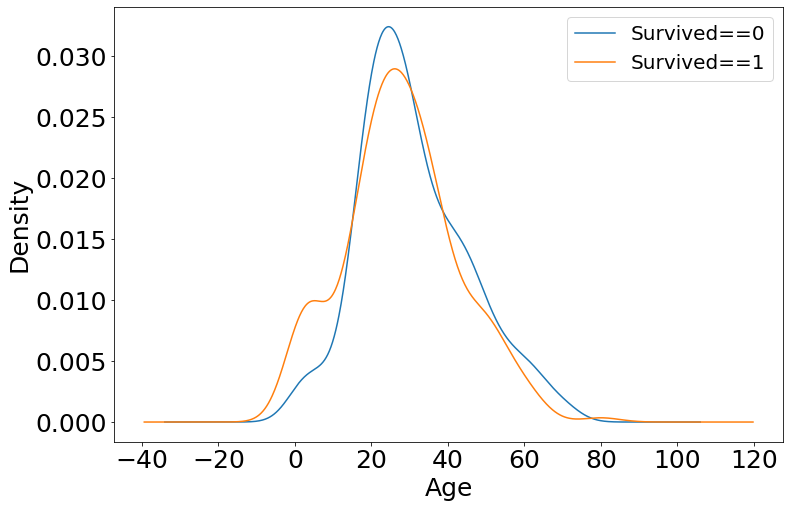

In [13]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

ax = train_df.query('Survived == 0')['Age'].plot(
    kind='density',figsize=(12,8),fontsize=25
)

train_df.query('Survived == 1')['Age'].plot(
    kind='density',figsize=(12,8),fontsize=25
)

ax.legend(['Survived==0','Survived==1'],fontsize = 20)
ax.set_ylabel('Density',fontsize = 25)
ax.set_xlabel('Age',fontsize = 25)
plt.show()

### 数据预处理

In [14]:
def preprocessing(dfdata):

    dfresult= pd.DataFrame()

    #对船票类型Pclass(1, 2, 3)进行one-hot编码，新生成的列的名称为Pclass_1、Pclass_2、Pclass_3
    dfPclass = pd.get_dummies(dfdata['Pclass'])
    dfPclass.columns = ['Pclass_' +str(x) for x in dfPclass.columns ]
    dfresult = pd.concat([dfresult,dfPclass],axis = 1)

    #对性别Sex(male, female)进行one-hot编码，新生成的列的名称为male、female
    dfSex = pd.get_dummies(dfdata['Sex'])
    dfresult = pd.concat([dfresult,dfSex],axis = 1)

    #将年龄Age的缺省值填充为0，并新增一列Age_null
    dfresult['Age'] = dfdata['Age'].fillna(0)
    dfresult['Age_null'] = pd.isna(dfdata['Age']).astype('int32')

    #SibSp,Parch,Fare
    dfresult['SibSp'] = dfdata['SibSp']
    dfresult['Parch'] = dfdata['Parch']
    dfresult['Fare'] = dfdata['Fare']

    #Carbin
    dfresult['Cabin_null'] =  pd.isna(dfdata['Cabin']).astype('int32')

    #将登船港口Embarked(S、C、Q)进行one-hot编码，
    dfEmbarked = pd.get_dummies(dfdata['Embarked'],dummy_na=True)
    dfEmbarked.columns = ['Embarked_' + str(x) for x in dfEmbarked.columns]
    dfresult = pd.concat([dfresult,dfEmbarked],axis = 1)

    return(dfresult)

x_train = preprocessing(train_df)
y_train = train_df['Survived'].values

x_test = preprocessing(test_df)
y_test = test_df['Survived'].values

print("x_train.shape =", x_train.shape )
print("x_test.shape =", x_test.shape )

# train_df.head(3)
x_train.head(3)

x_train.shape = (712, 15)
x_test.shape = (179, 15)


,Pclass_1,Pclass_2,Pclass_3,female,male,Age,Age_null,SibSp,Parch,Fare,Cabin_null,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,1,0,0,0,1,55.0,0,0,0,30.5000,0,0,0,1,0
1,1,0,0,1,0,49.0,0,1,0,76.7292,0,1,0,0,0
2,0,1,0,1,0,36.0,0,0,0,13.0000,1,0,0,1,0


### 定义模型

In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, activation='relu', input_shape=(15,)),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 20)                320       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


### 训练模型

In [17]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['AUC'])

history = model.fit(x_train,y_train,
                    batch_size= 64,
                    epochs= 30,
                    validation_split=0.2 #分割一部分训练数据用于验证
)

Train on 569 samples, validate on 143 samples
Epoch 1/30
569/569 [==============================] - 1s 1ms/sample - loss: 0.8794 - AUC: 0.7028 - val_loss: 0.7005 - val_AUC: 0.6667
Epoch 2/30
569/569 [==============================] - 0s 44us/sample - loss: 0.6575 - AUC: 0.6916 - val_loss: 0.6721 - val_AUC: 0.6804
Epoch 3/30
569/569 [==============================] - 0s 44us/sample - loss: 0.6129 - AUC: 0.7187 - val_loss: 0.6406 - val_AUC: 0.6797
Epoch 4/30
569/569 [==============================] - 0s 47us/sample - loss: 0.5963 - AUC: 0.7379 - val_loss: 0.6156 - val_AUC: 0.6960
Epoch 5/30
569/569 [==============================] - 0s 43us/sample - loss: 0.5858 - AUC: 0.7568 - val_loss: 0.6130 - val_AUC: 0.7015
Epoch 6/30
569/569 [==============================] - 0s 42us/sample - loss: 0.5789 - AUC: 0.7634 - val_